# AQMS Modeling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import os
os.environ["KERAS_BACKEND"] = "torch"
import keras

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
    
torch.mps.set_per_process_memory_fraction(0.0)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

tensor([1.], device='mps:0')


## Load Dataset

In [3]:
data = pd.read_csv("dataset/Indeks Standar Pencemar Udara di Provinsi DKI Jakarta 2021.csv")
data['tanggal'] = pd.to_datetime(data['tanggal'])
data.set_index('tanggal', inplace=True)
data = data[['co']]

data.head()

,co
tanggal,
2021-01-01,29
2021-01-02,38
2021-01-03,25
2021-01-04,24
2021-01-05,24


In [4]:
data.isnull().sum()

co    0
dtype: int64

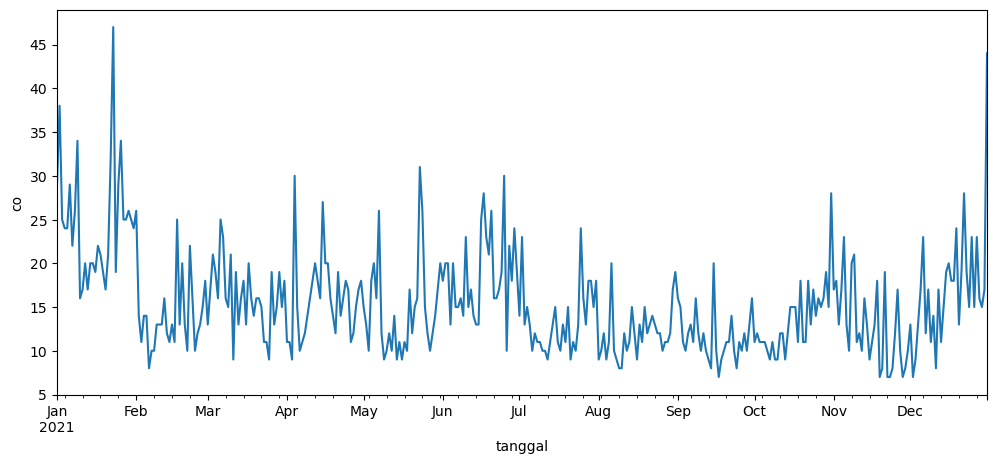

In [5]:
data["co"].plot(figsize = (12,5))
plt.ylabel("co")
plt.show()

## Decomposition

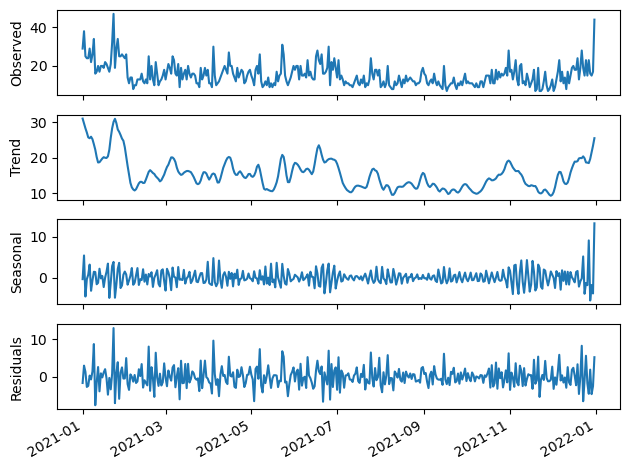

In [8]:
advanced_decomposition = STL(data["co"], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()